In [1]:
!pip install qiskit qiskit-aer
!pip install matplotlib
!pip install pylatexenc

Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


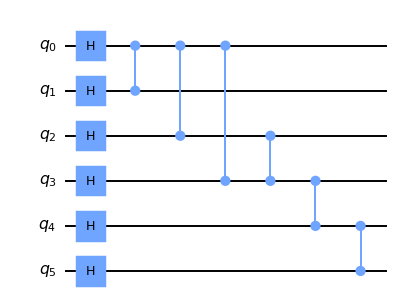

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import math

# Map logical node names -> qubit indices
nodes = ['S','A','B','C','D','T']
node_index = {n:i for i,n in enumerate(nodes)}

# Undirected graph edges for CZ entangling (choose edges to match the sketch)
edges = [
    ('S','A'),
    ('S','B'),
    ('S','C'),   # long diagonal in the sketch
    ('B','C'),   # B -> C in sketch (we model as undirected CZ)
    ('C','D'),
    ('T','D')    # T -> D vertical link
]

# Build circuit: H on every qubit, then CZ on each edge -> prepares graph state |G>
qr = QuantumRegister(len(nodes), 'q')
qc_graph = QuantumCircuit(qr, name='graph_state')

# prepare |+> on each vertex
for q in qr:
    qc_graph.h(q)

# apply CZ for each undirected edge
for (u,v) in edges:
    i, j = node_index[u], node_index[v]
    qc_graph.cz(qr[i], qr[j])

# draw
qc_graph.draw('mpl', style='clifford', scale=0.7, fold=-1)

Counts: {'0': 882, '1': 142}


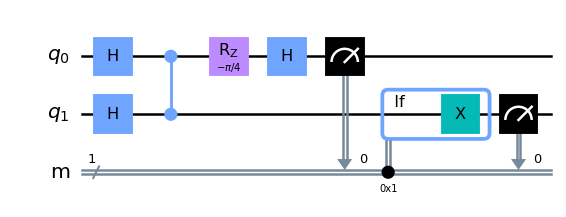

In [9]:
import numpy as np

# Define rotation parameter for measurement basis (example)
theta = np.pi / 4  # adjustable based on decision boundary

# Create registers
qr = QuantumRegister(2, 'q')     # q0: input, q1: output
cr = ClassicalRegister(1, 'm')   # store measurement of q0
qc = QuantumCircuit(qr, cr)

# --- Step 1: Prepare logical input state |ψ⟩ = |+⟩
qc.h(qr[0])  # superposition input representing encoded coordinate

# --- Step 2: Prepare ancilla/output qubit in |+⟩
qc.h(qr[1])

# --- Step 3: Create entanglement edge of the graph (CZ link)
qc.cz(qr[0], qr[1])

# --- Step 4: Measure q0 in rotated basis M^{-θ} = H · Rz(-θ)
qc.rz(-theta, qr[0])
qc.h(qr[0])
qc.measure(qr[0], cr[0])

# --- Step 5: Adaptive correction on q1 depending on measurement outcome
with qc.if_test((cr, 1)):   # conditionally apply operations if cr == 1
    qc.x(qr[1])

# --- Step 6: Measure output qubit to obtain decision result
qc.measure(qr[1], cr[0])  # reuse same classical bit for simplicity

# --- Step 7: Execute simulation
sim = AerSimulator()
tqc = transpile(qc, sim)
job = sim.run(tqc, shots=1024)
res = job.result()
counts = res.get_counts()

print("Counts:", counts)
qc.draw('mpl', style='clifford', scale=0.9, fold=-1)